# Exploratory Data Analysis (EDA)

**Notebook Purpose:** Analyze feature distributions, relationships, and data quality to inform modeling decisions for residential solar adoption.

---

## Table of Contents
1. Target Variable Analysis
2. Assess Sunlight Feature Importance
3. Modeling Features EDA

---

## Analysis Overview

This notebook performs comprehensive EDA on the county-level solar adoption dataset to:
1. **Validate data transformations** (target variable log-transformation)
2. **Assess feature importance** (solar resource control variable)
3. **Identify relationships** (correlations, bivariate patterns)
4. **Detect issues** (missing data, outliers, multicollinearity)
5. **Guide modeling decisions** (feature selection, transformations, interactions)

---

## Key Decisions

### **1. Target Variable: Log Transformation**
- **Original**: `adoption_rate_per_1k_pop` (highly right-skewed)
- **Transformed**: `log_adoption_rate_pop` = log(rate + 0.01)
- **Rationale**: Reduces skewness, stabilizes variance for linear modeling

### **2. Solar Resource Variable: EXCLUDED**
- **Availability**: 632/1,280 counties (49.4% coverage)
- **Explanatory Power**:
  - Raw adoption rate: R² = 14% (threshold effect in highest quartile)
  - Log adoption rate: R² < 1% (minimal systematic relationship)
- **Decision**: Excluded from model due to:
  - Limited coverage (would lose 51% of sample)
  - Minimal explanatory power for log-transformed outcome
  - Research focuses on structural barriers conditional on adequate solar resource (actionable)

---

## Data Quality Summary

**Dataset**: `modeling_data/merged_solar_dataset.csv`
- **Observations**: 1,279 counties
- **Features**: 14 predictors + target
- **Missing Data**: Primarily in `avg_daily_sunlight` (51% missing)
- **Outliers**: Present in several features (detected via z-scores, IQR)

**Variable Categories**:
- **Outcome**: Log-transformed adoption rate
- **Affordability/Financing**: Median household income
- **Structural Feasibility**: Homeownership rate, single-family home %
- **Demographics**: Education, race/ethnicity, household size
- **Geography**: Population density, urbanicity (categorical)
- **Policy**: Net metering, solar incentives (state-level)

---

## Key Findings

### **Strongest Predictors** (Correlation with log adoption):
Top positive correlations will be identified in correlation analysis section

### **Data Issues to Address**:
1. **Skewed Features**: Several predictors highly skewed → consider transformations
2. **Multicollinearity**: Check for high correlations between predictors (|r| > 0.7)
3. **Outliers**: Multivariate outliers detected → assess impact on model
4. **Missing Data**: `avg_daily_sunlight` excluded; all other features complete

---

## Analyses Performed

1. **Distribution Analysis**: Assess normality, skewness, outliers
2. **Feature Importance**: Correlation, quartile analysis, simple regression
3. **Bivariate Relationships**: Scatter plots with regression lines
4. **Multicollinearity Check**: Correlation matrix, pairwise comparisons
5. **Categorical Analysis**: Urbanicity distribution and ANOVA
6. **Outlier Detection**: Univariate (IQR) and multivariate (z-scores)

---

## Next Steps → Modeling (03_modeling.ipynb)

1. Drop `avg_daily_sunlight` from feature set
2. Handle skewed features (log transformations where appropriate)
3. Standardize/scale features for regularization (Elastic Net)
4. Consider interaction terms (income × homeownership, policy synergies)
5. Address multicollinearity if detected
6. Train/validation split with cross-validation

---

## Output Expectations

- Clear understanding of feature distributions
- Evidence-based justification for excluding solar resource variable
- Identification of key predictors for barrier analysis
- Data quality checks passed (minimal missing data, outliers documented)

In [12]:
# import Statements

# Third-party imports - data manipulation
import numpy as np
import pandas as pd

# Third-party imports - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Third-party imports - statistical analysis
from scipy import stats
from scipy.stats import f_oneway, linregress, zscore

# Third-party imports - machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [13]:
# Load the prepared dataset
model_df = pd.read_csv('modeling_data/merged_solar_dataset.csv')

## 1. Target Variable Analysis

Distribution Check: Do We Need Log Transformation?

Adoption Rate per 1k Population:
count    1.279000e+03
mean     6.942501e+00
std      1.653688e+01
min      2.543076e-07
25%      1.111063e-01
50%      9.398719e-01
75%      5.319501e+00
max      1.297814e+02
Name: adoption_rate_per_1k_pop, dtype: float64

Skewness: 3.995
  → Highly skewed: Transformation recommended


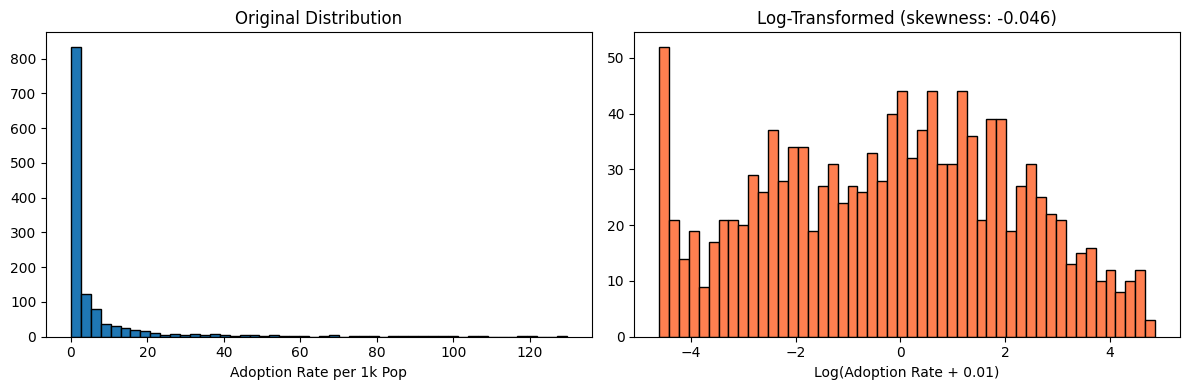


DECISION:
Use LOG-TRANSFORMED (log_adoption_rate_pop)
   → Reduces skewness and stabilizes variance


In [14]:
# Verify if target log transformation is necessary
print("=" * 70)
print("Distribution Check: Do We Need Log Transformation?")
print("=" * 70)

# Basic statistics
print(f"\nAdoption Rate per 1k Population:")
print(model_df['adoption_rate_per_1k_pop'].describe())

skewness = model_df['adoption_rate_per_1k_pop'].skew()
print(f"\nSkewness: {skewness:.3f}")

if abs(skewness) < 0.5:
    print("  → Fairly symmetric: NO transformation needed")
elif abs(skewness) < 1.0:
    print("  → Moderately skewed: Transformation may help")
else:
    print("  → Highly skewed: Transformation recommended")

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original
axes[0].hist(model_df['adoption_rate_per_1k_pop'], bins=50, edgecolor='black')
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Adoption Rate per 1k Pop')

# Log-transformed
log_rate = np.log(model_df['adoption_rate_per_1k_pop'] + 0.01)
axes[1].hist(log_rate, bins=50, edgecolor='black', color='coral')
axes[1].set_title(f'Log-Transformed (skewness: {log_rate.skew():.3f})')
axes[1].set_xlabel('Log(Adoption Rate + 0.01)')

plt.tight_layout()
plt.show()

# RECOMMENDATION
print("\n" + "=" * 70)
print("DECISION:")
if abs(skewness) < 0.5:
    print("Use ORIGINAL scale (adoption_rate_per_1k_pop)")
    print("   → Data is symmetric enough for linear models")
else:
    print("Use LOG-TRANSFORMED (log_adoption_rate_pop)")
    print("   → Reduces skewness and stabilizes variance")

## 2. Assess Sunlight Feature Importance

Assessing Sunlight Feature Importance: adoption_rate_per_1k_pop

1. CORRELATION: r = 0.3731

2. ADOPTION_RATE_PER_1K_POP BY SUNLIGHT QUARTILE
                        mean  count
sunlight_quartile                  
Q1 (Low)            5.534797    158
Q2                  7.245569    158
Q3                  5.373472    158
Q4 (High)          27.210359    158

   ANOVA: F = 46.50, p = 0.0000

3. REGRESSION: R² = 0.1392
   Sunlight explains 13.92% of variance in adoption_rate_per_1k_pop


/var/folders/rs/nq6c88xs43j3xx3wd29dm_cr0000gn/T/ipykernel_8988/1929255184.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_summary = df_with_sunlight.groupby('sunlight_quartile')[target_var].agg(['mean', 'count'])
/var/folders/rs/nq6c88xs43j3xx3wd29dm_cr0000gn/T/ipykernel_8988/1929255184.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[target_var].values for name, group in df_with_sunlight.groupby('sunlight_quartile')]


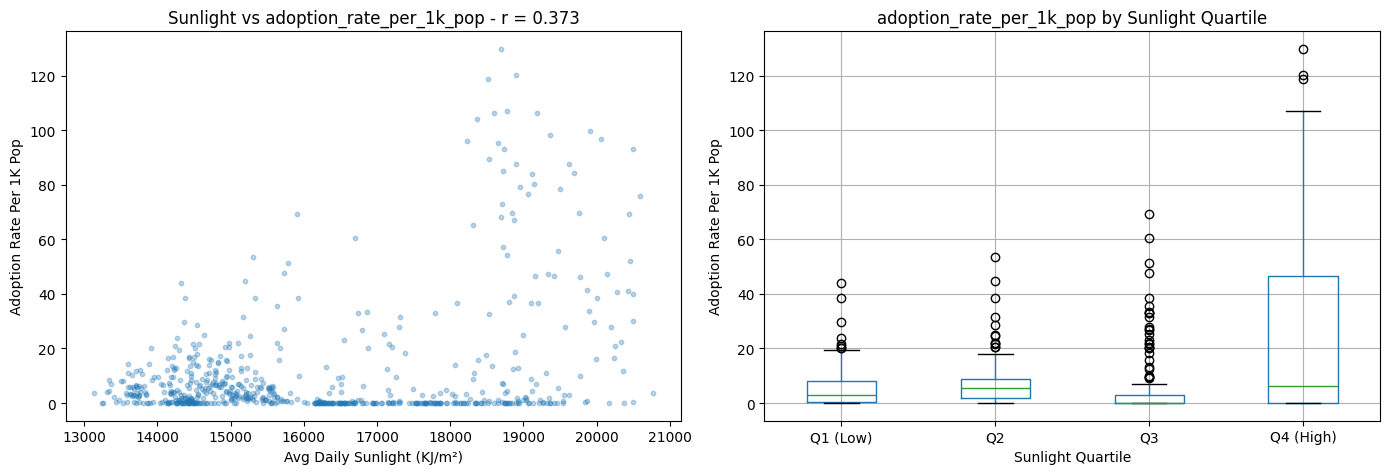


DECISION for adoption_rate_per_1k_pop:
 BORDERLINE (5% ≤ R² < 15%) - consider research context



Assessing Sunlight Feature Importance: log_adoption_rate_pop

1. CORRELATION: r = 0.0299

2. LOG_ADOPTION_RATE_POP BY SUNLIGHT QUARTILE
                       mean  count
sunlight_quartile                 
Q1 (Low)           0.447933    158
Q2                 1.088486    158
Q3                -1.294248    158
Q4 (High)          1.111006    158

   ANOVA: F = 33.39, p = 0.0000

3. REGRESSION: R² = 0.0009
   Sunlight explains 0.09% of variance in log_adoption_rate_pop


/var/folders/rs/nq6c88xs43j3xx3wd29dm_cr0000gn/T/ipykernel_8988/1929255184.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_summary = df_with_sunlight.groupby('sunlight_quartile')[target_var].agg(['mean', 'count'])
/var/folders/rs/nq6c88xs43j3xx3wd29dm_cr0000gn/T/ipykernel_8988/1929255184.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[target_var].values for name, group in df_with_sunlight.groupby('sunlight_quartile')]


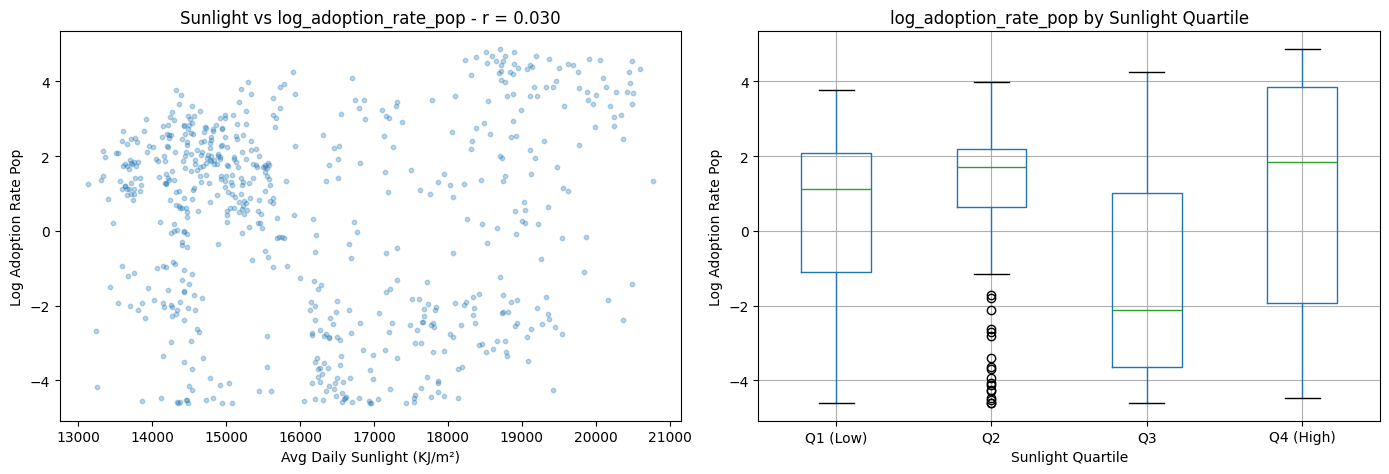


DECISION for log_adoption_rate_pop:
 DROP sunlight (R² < 5%)





In [15]:
# Because sunlight data is available in 632/1,280 counties (49.4%), it could either be imputed, 
# dropped, or data restricted to counties where it is available.
# Restricting data is not ideal as it reduces sample size significantly.
# Imputation could introduce bias if sunlight is correlated with adoption.
# Therefore, we need to assess how important sunlight is as a predictor.
# Here, we assess its importance using correlation, quartile analysis, and regression.

# Define target variables to test
target_variables = ['adoption_rate_per_1k_pop', 'log_adoption_rate_pop']

for target_var in target_variables:
    print("=" * 70)
    print(f"Assessing Sunlight Feature Importance: {target_var}")
    print("=" * 70)
    
    # Filter to rows with sunlight data
    df_with_sunlight = model_df[model_df['avg_daily_sunlight'].notna()].copy()
    
    # 1. CORRELATION
    corr = df_with_sunlight[['avg_daily_sunlight', target_var]].corr().iloc[0, 1]
    print(f"\n1. CORRELATION: r = {corr:.4f}")
    
    # 2. QUARTILE ANALYSIS
    df_with_sunlight['sunlight_quartile'] = pd.qcut(
        df_with_sunlight['avg_daily_sunlight'], 
        q=4, 
        labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']
    )
    
    print(f"\n2. {target_var.upper()} BY SUNLIGHT QUARTILE")
    quartile_summary = df_with_sunlight.groupby('sunlight_quartile')[target_var].agg(['mean', 'count'])
    print(quartile_summary)
    
    # ANOVA test
    groups = [group[target_var].values for name, group in df_with_sunlight.groupby('sunlight_quartile')]
    f_stat, p_value = f_oneway(*groups)
    print(f"\n   ANOVA: F = {f_stat:.2f}, p = {p_value:.4f}")
    
    # 3. SIMPLE REGRESSION
    X = df_with_sunlight[['avg_daily_sunlight']].values
    y = df_with_sunlight[target_var].values
    
    model = LinearRegression()
    model.fit(X, y)
    r2 = r2_score(y, model.predict(X))
    
    print(f"\n3. REGRESSION: R² = {r2:.4f}")
    print(f"   Sunlight explains {r2*100:.2f}% of variance in {target_var}")
    
    # 4. VISUALIZATION
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].scatter(df_with_sunlight['avg_daily_sunlight'], 
                    df_with_sunlight[target_var],
                    alpha=0.3, s=10)
    axes[0].set_xlabel('Avg Daily Sunlight (KJ/m²)')
    axes[0].set_ylabel(target_var.replace('_', ' ').title())
    axes[0].set_title(f'Sunlight vs {target_var} - r = {corr:.3f}')
    
    df_with_sunlight.boxplot(column=target_var, by='sunlight_quartile', ax=axes[1])
    axes[1].set_xlabel('Sunlight Quartile')
    axes[1].set_ylabel(target_var.replace('_', ' ').title())
    axes[1].set_title(f'{target_var} by Sunlight Quartile')
    plt.suptitle('')
    
    plt.tight_layout()
    plt.show()
    
    # DECISION
    print("\n" + "=" * 70)
    print(f"DECISION for {target_var}:")
    if r2 < 0.05:
        print(" DROP sunlight (R² < 5%)")
    elif r2 < 0.15:
        print(" BORDERLINE (5% ≤ R² < 15%) - consider research context")
    else:
        print(" KEEP sunlight (R² ≥ 15%)")
    
    print("\n" * 2)  # Add spacing between iterations

Conclusions on solar resource importance:

- Using raw adoption rates, sunlight explains ~14% of the variance, mostly driven by counties in the highest sunlight quartile.

- When modeling log-adoption (proportional effects), sunlight explains <1% of the variance.

- Indicates a threshold effect: very high solar resource can affect absolute adoption, but sunlight does not systematically scale adoption across most regions.

- Sunlight data is available in only ~50% of counties and has minimal explanatory power.

- **Decision:** Sunlight is excluded from the main analysis for simplicity and robustness.

## 3. Modeling Features EDA

EXPLORATORY DATA ANALYSIS: MODELING FEATURES

[1] DATASET OVERVIEW
--------------------------------------------------------------------------------
Shape: (1279, 17)
Observations: 1,279
Features: 14 (excluding target and capacity metrics)
Memory usage: 0.22 MB

Variable Types:
float64    16
object      1
Name: count, dtype: int64

Categorical Variables:
  ['urbanicity']

[2] MISSING DATA ANALYSIS
--------------------------------------------------------------------------------

Variables with missing data:
          Variable  Missing_Count  Missing_Percent
avg_daily_sunlight            647            50.59

DECISION:
  * avg_daily_sunlight: EXCLUDED from modeling (51% missing, minimal explanatory power)
    Rationale: Analysis above showed R-squared < 1% for log-transformed target
    Impact: Keeping it would lose 51% of sample with negligible predictive gain

[3] TARGET VARIABLE: log_adoption_rate_pop
--------------------------------------------------------------------------------

Des

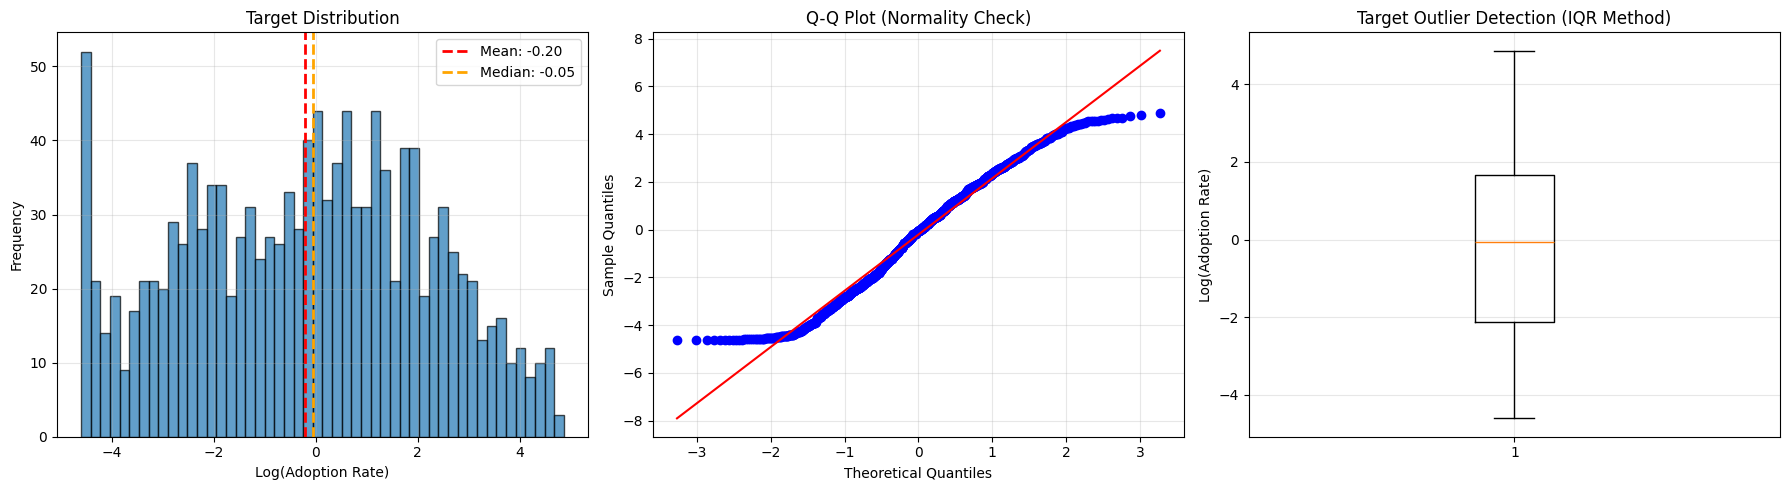


  Q-Q Plot Interpretation:
    The Q-Q plot compares our data quantiles to theoretical normal distribution quantiles
    If points follow the diagonal line closely -> data is approximately normal
    Deviations in tails -> heavier/lighter tails than normal distribution

  Outlier Detection Method:
    We use the standard IQR method with 1.5 times the interquartile range
    This is Tukey's conventional threshold for identifying outliers
    Formula: Outliers are values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    where IQR = Q3 - Q1

    Q1 (25th percentile): -2.111
    Q3 (75th percentile): 1.673
    IQR: 3.784
    Lower fence: -7.788
    Upper fence: 7.350

  Outliers detected: 0 (0.0%)
    Note: These outliers represent real variation and will be RETAINED

[4] NUMERIC PREDICTORS ANALYSIS
--------------------------------------------------------------------------------

Numeric predictors: 12
  median_household_income, homeownership_rate, single_family_home_pct, pct_bachelors_or_higher, 

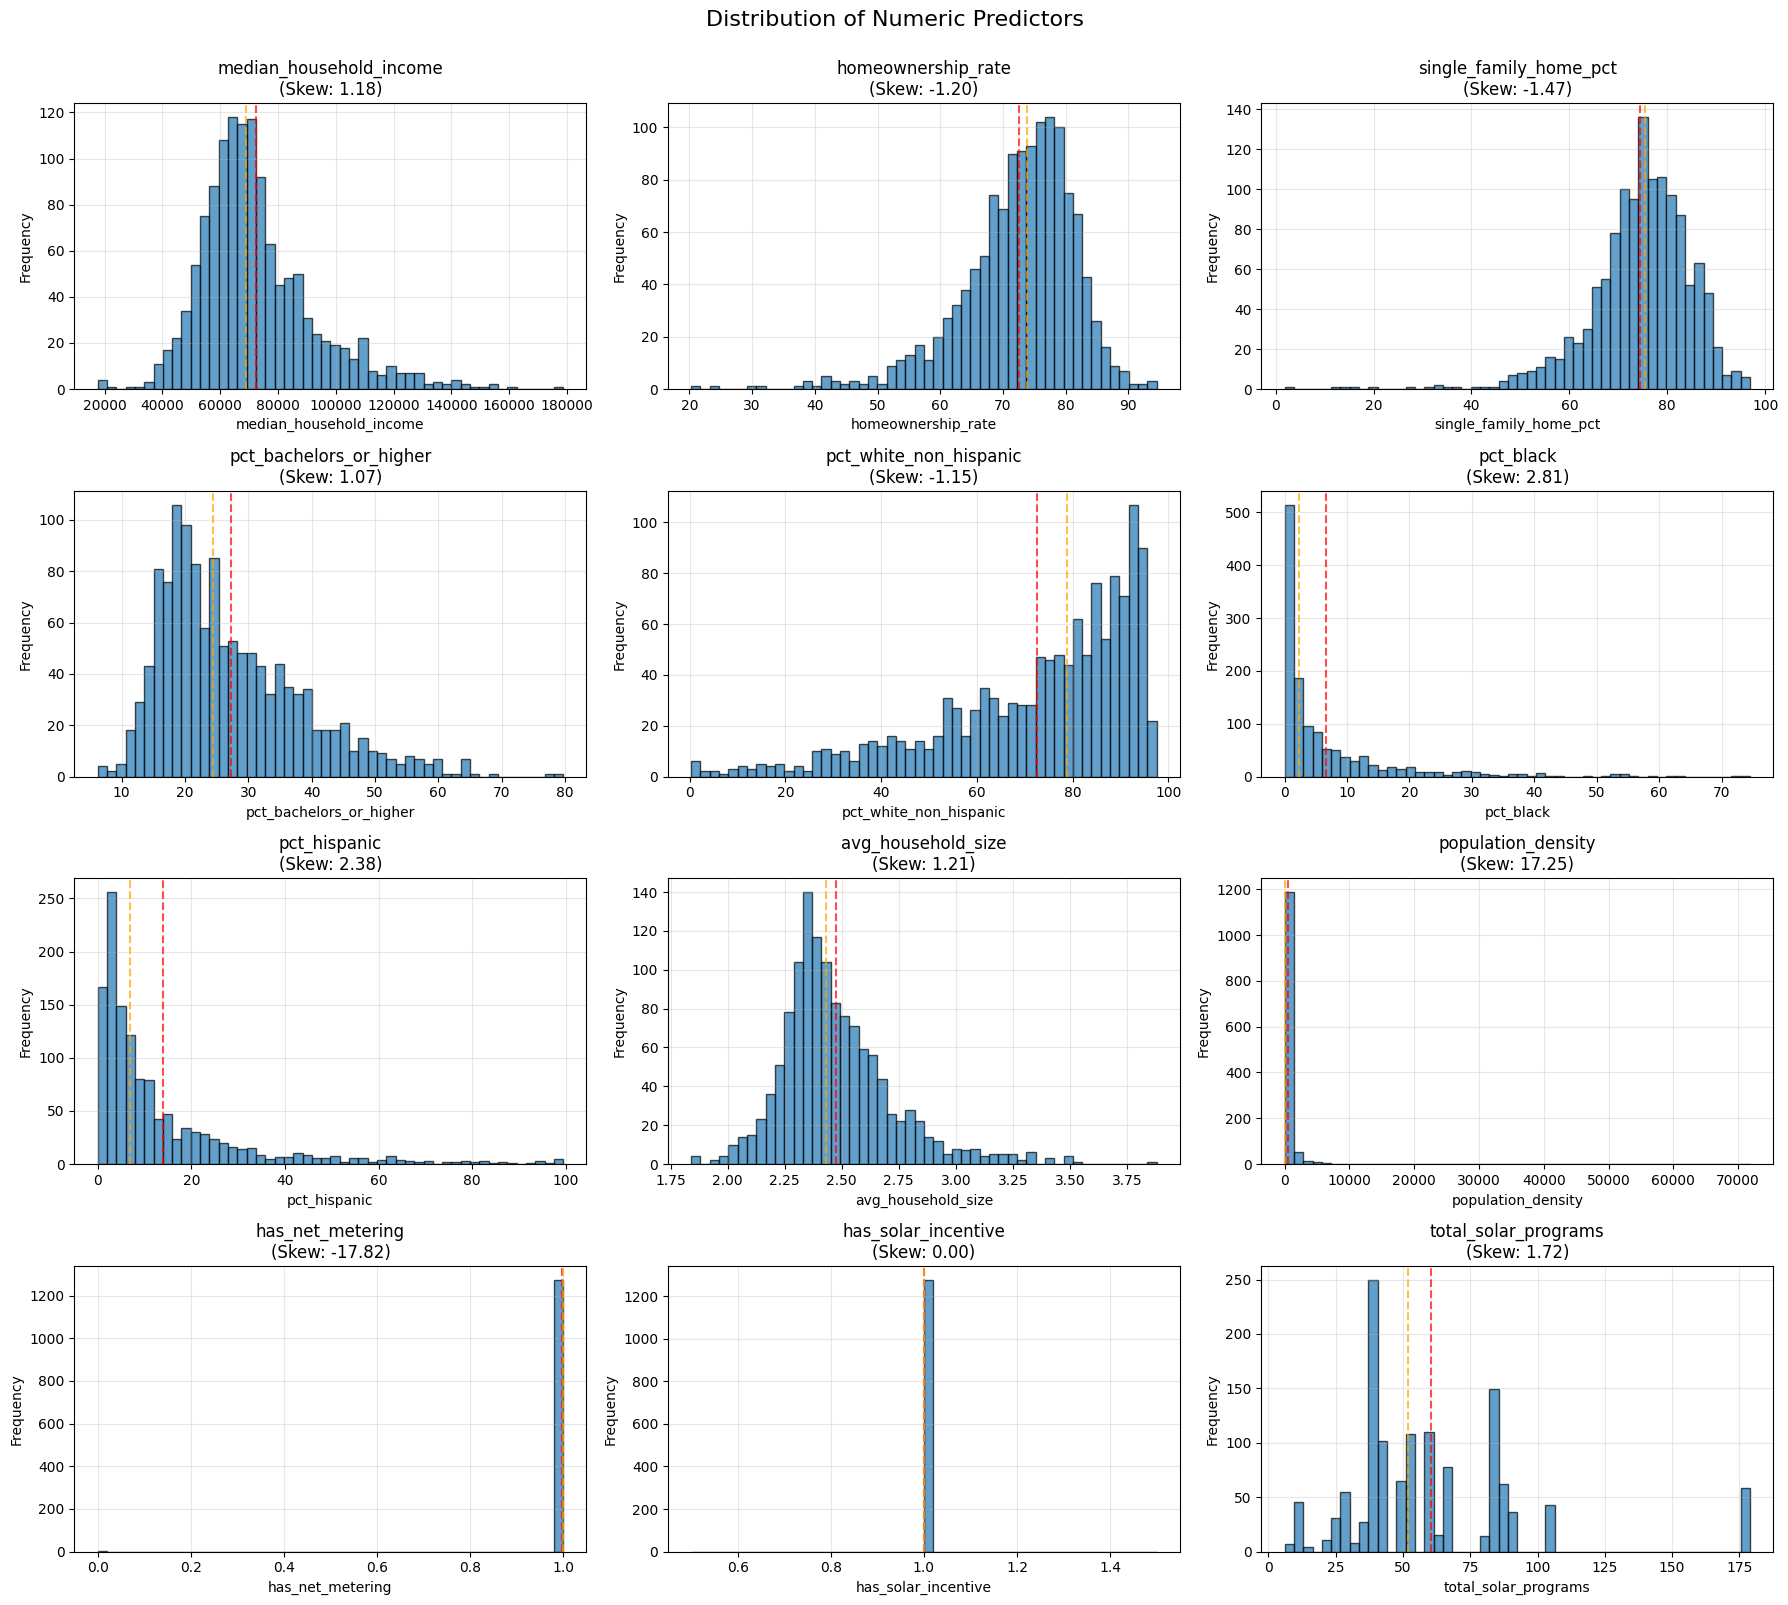


[5] CATEGORICAL PREDICTOR: urbanicity
--------------------------------------------------------------------------------

Urbanicity Distribution:
Category  Count  Percent
   Rural    916    71.62
Suburban    238    18.61
   Urban    125     9.77


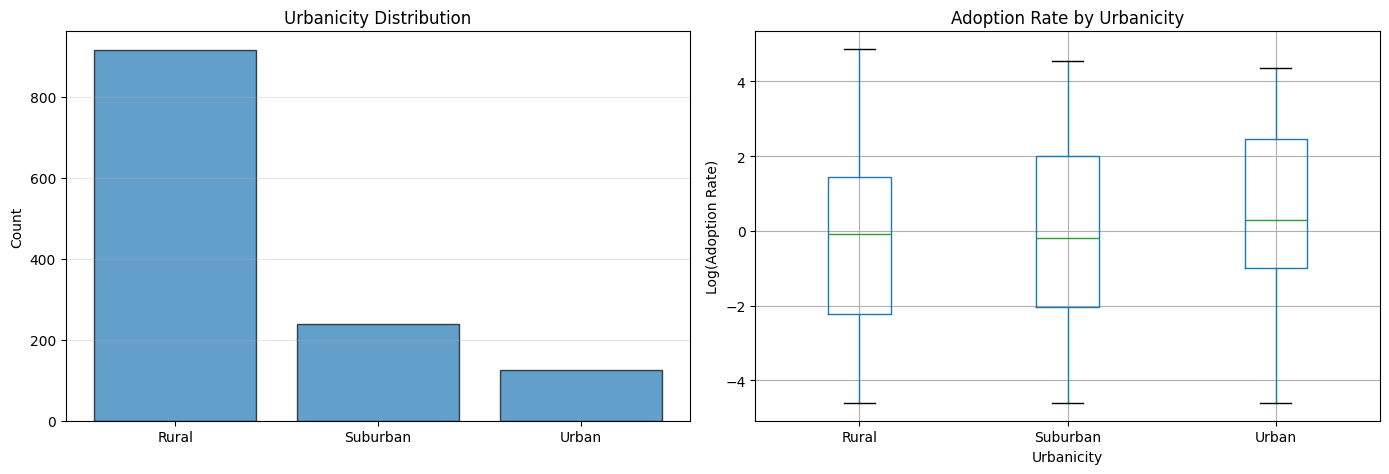


  ANOVA Test (urbanicity vs adoption):
    Interpretation: ANOVA tests if group means differ significantly
    F-statistic = (Variance Between Groups) / (Variance Within Groups)
    Large F-statistic -> group means differ more than random chance

    F-statistic: 5.32
    p-value: 0.0050
    -> Significant difference between urbanicity groups (p < 0.05)
    -> RECOMMENDATION: INCLUDE urbanicity in model

[6] CORRELATION ANALYSIS
--------------------------------------------------------------------------------

Correlations with Target (log_adoption_rate_pop):
median_household_income    0.330410
pct_bachelors_or_higher    0.317341
total_solar_programs       0.187876
has_net_metering           0.098957
population_density         0.050216
pct_white_non_hispanic     0.045009
single_family_home_pct     0.029608
pct_hispanic               0.002426
avg_household_size        -0.000186
homeownership_rate        -0.059160
pct_black                 -0.200677
has_solar_incentive             NaN
Na

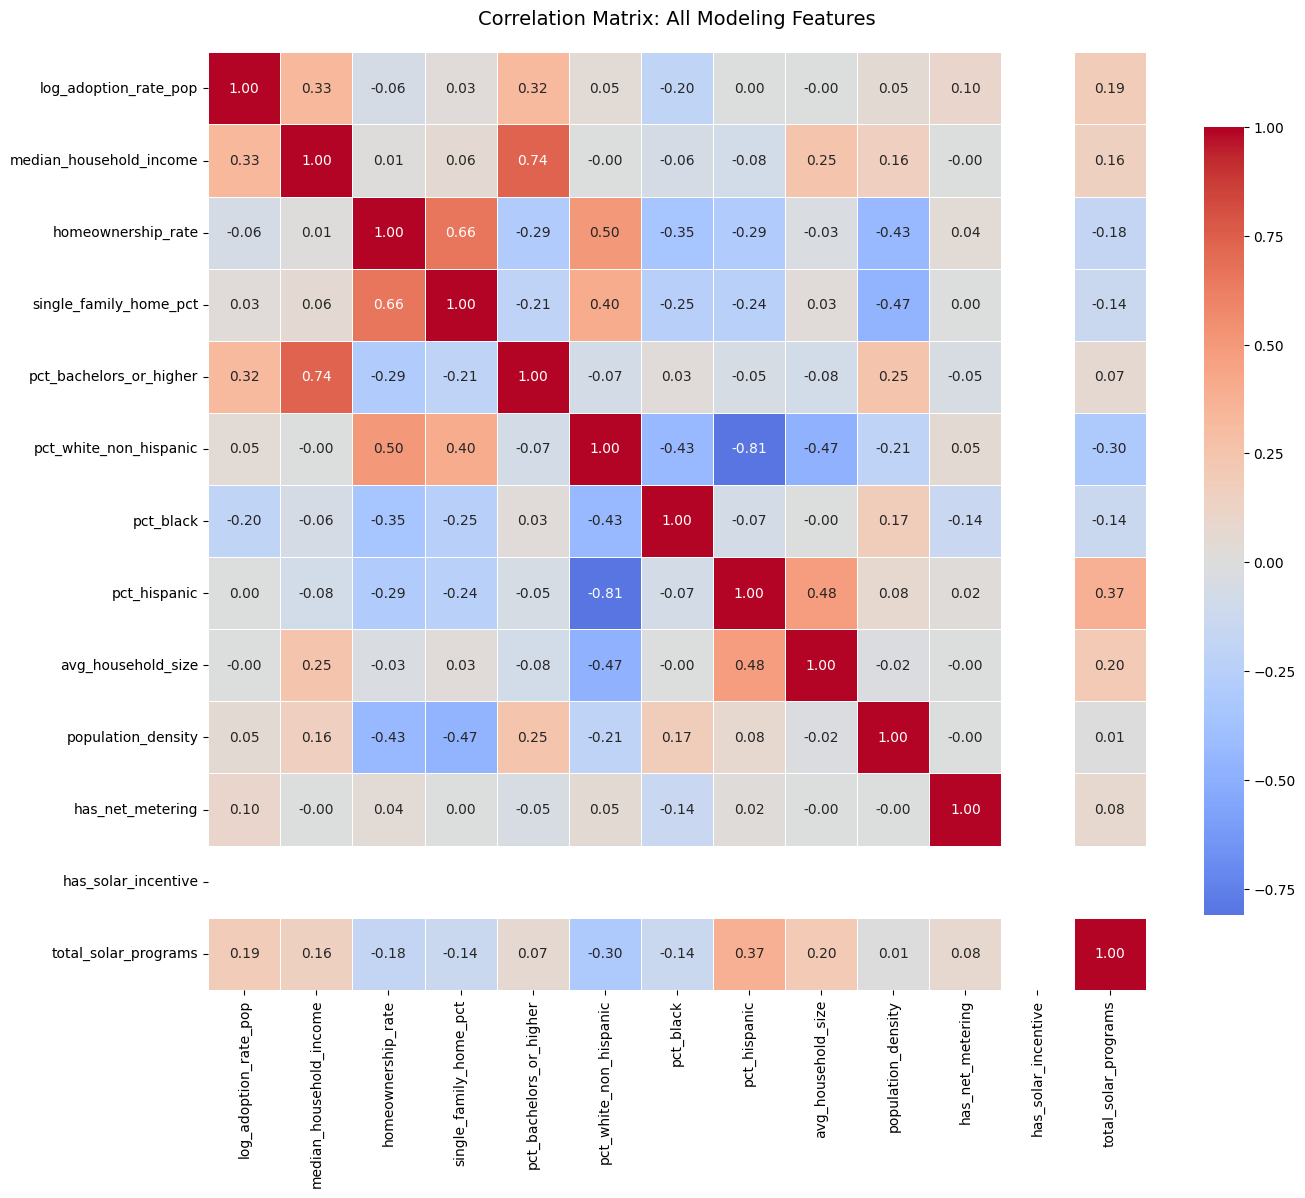


[7] BIVARIATE RELATIONSHIPS: Key Predictors vs Target
--------------------------------------------------------------------------------

Top 6 predictors by correlation:
  * median_household_income: r = 0.330
  * pct_bachelors_or_higher: r = 0.317
  * total_solar_programs: r = 0.188
  * has_net_metering: r = 0.099
  * population_density: r = 0.050
  * pct_white_non_hispanic: r = 0.045


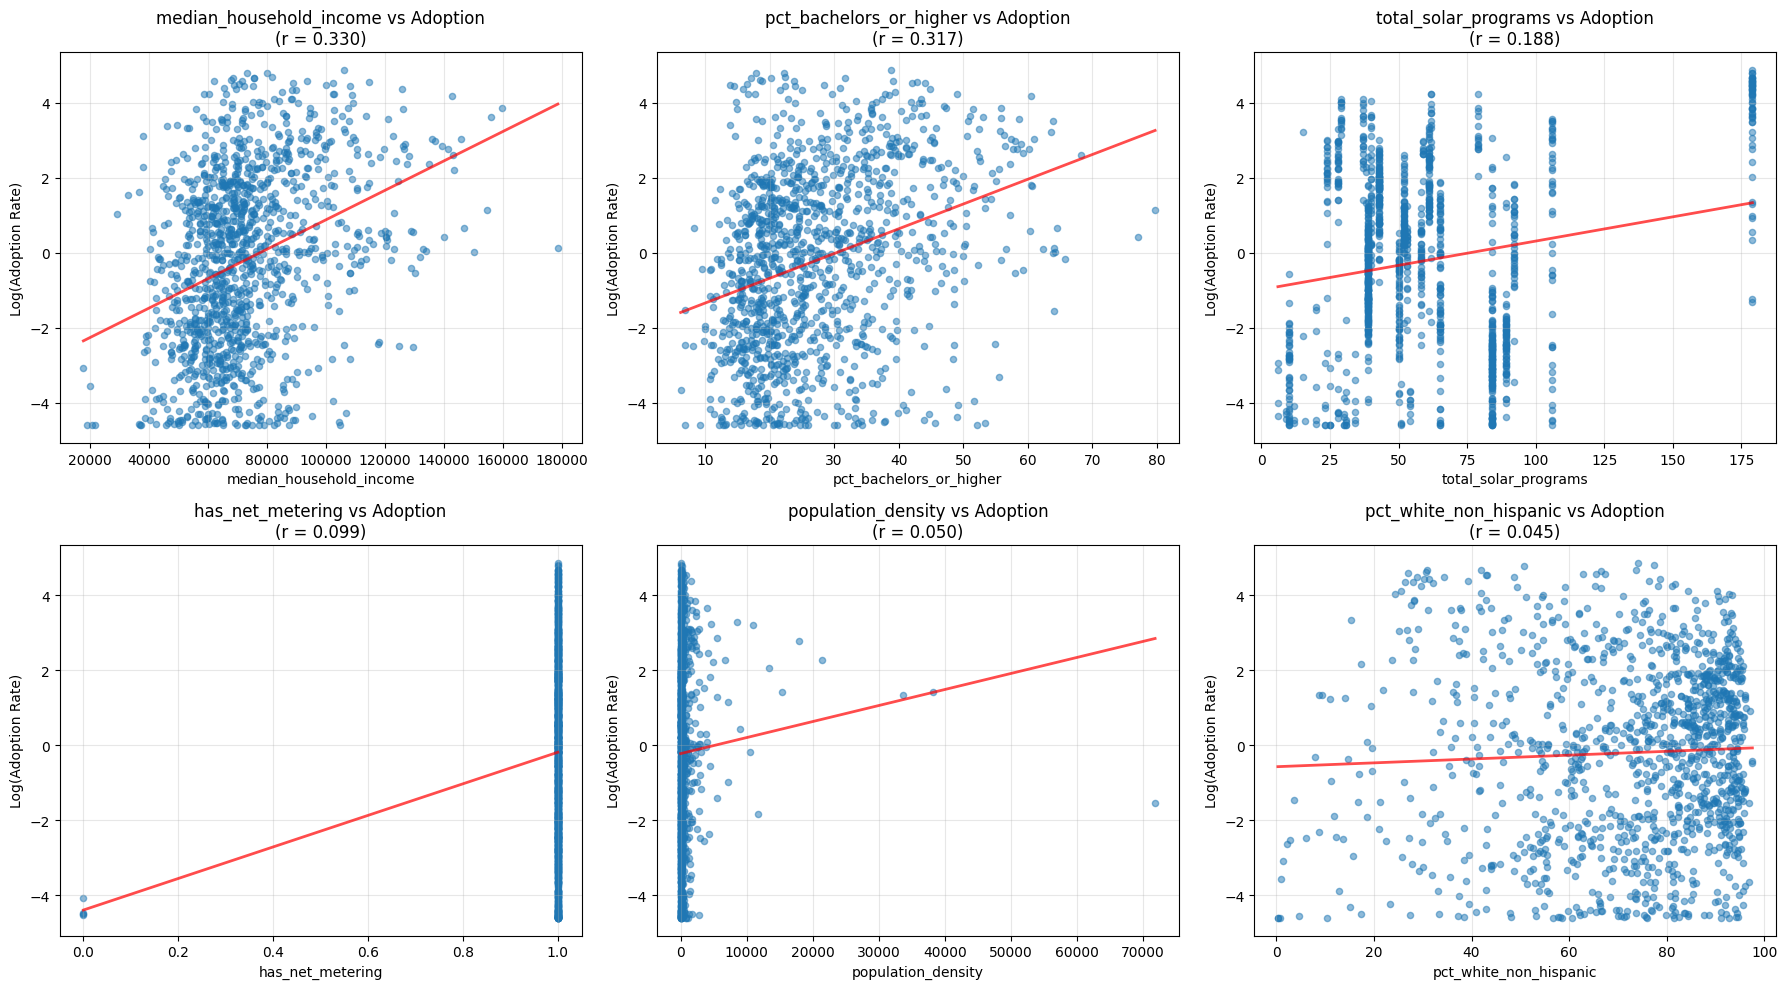


[8] OUTLIER DETECTION
--------------------------------------------------------------------------------

Multivariate outliers (z-score > 3): 167 (13.1%)

Variables with most outliers:
total_solar_programs       58
pct_black                  34
pct_hispanic               33
avg_household_size         22
homeownership_rate         19
median_household_income    18
pct_white_non_hispanic     14
single_family_home_pct     13
pct_bachelors_or_higher    12
population_density         11
dtype: int64

  OUTLIER HANDLING RECOMMENDATION:
    -> Use WINSORIZATION instead of deletion
    -> Winsorization caps extreme values at a percentile threshold (e.g., 1st and 99th)
    -> Rationale:
       * Preserves sample size (no data loss)
       * Retains information about extreme cases (just reduces their influence)
       * Prevents model from being overly sensitive to a few extreme counties
       * Geographic outliers (e.g., NYC high density) represent real phenomena, not errors
    -> Implementatio

/var/folders/rs/nq6c88xs43j3xx3wd29dm_cr0000gn/T/ipykernel_8988/170464276.py:371: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(zscore(model_df[numeric_predictors].fillna(model_df[numeric_predictors].mean())))


In [16]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS: MODELING FEATURES
# ============================================================================

print("=" * 80)
print("EXPLORATORY DATA ANALYSIS: MODELING FEATURES")
print("=" * 80)

# -----------------------------------------------------------------------------
# 1. BASIC OVERVIEW
# -----------------------------------------------------------------------------
print("\n[1] DATASET OVERVIEW")
print("-" * 80)
print(f"Shape: {model_df.shape}")
print(f"Observations: {len(model_df):,}")
print(f"Features: {model_df.shape[1] - 3} (excluding target and capacity metrics)")
print(f"Memory usage: {model_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nVariable Types:")
print(model_df.dtypes.value_counts())

print("\nCategorical Variables:")
categorical_cols = model_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"  {categorical_cols if categorical_cols else 'None'}")

# -----------------------------------------------------------------------------
# 2. MISSING DATA ANALYSIS
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[2] MISSING DATA ANALYSIS")
print("-" * 80)

missing_counts = model_df.isnull().sum()
missing_pct = (missing_counts / len(model_df) * 100).round(2)

missing_summary = pd.DataFrame({
    'Variable': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_pct.values
}).sort_values('Missing_Count', ascending=False)

if missing_summary['Missing_Count'].sum() > 0:
    print("\nVariables with missing data:")
    print(missing_summary[missing_summary['Missing_Count'] > 0].to_string(index=False))
    
    print("\nDECISION:")
    print("  * avg_daily_sunlight: EXCLUDED from modeling (51% missing, minimal explanatory power)")
    print("    Rationale: Analysis above showed R-squared < 1% for log-transformed target")
    print("    Impact: Keeping it would lose 51% of sample with negligible predictive gain")
else:
    print("\nNo missing data detected!")

# -----------------------------------------------------------------------------
# 3. TARGET VARIABLE ANALYSIS
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[3] TARGET VARIABLE: log_adoption_rate_pop")
print("-" * 80)

target_stats = model_df['log_adoption_rate_pop'].describe()
print(f"\nDescriptive Statistics:")
print(target_stats)

skewness = model_df['log_adoption_rate_pop'].skew()
kurtosis = model_df['log_adoption_rate_pop'].kurtosis()

print(f"\nDistribution Properties:")
print(f"  Skewness: {skewness:.3f}")
print(f"    Interpretation: Skewness measures asymmetry of a distribution")
if abs(skewness) < 0.5:
    print(f"    -> Approximately symmetric (close to normal distribution)")
    print(f"    -> Value near 0 indicates the distribution is well-balanced")
elif abs(skewness) < 1.0:
    print(f"    -> Moderately skewed")
else:
    print(f"    -> Highly skewed")

print(f"\n  Kurtosis (excess): {kurtosis:.3f}")
print(f"    Interpretation: Kurtosis measures 'tailedness' - how much extreme values occur")
print(f"    Excess kurtosis compares to normal distribution (0 = normal)")
if kurtosis < -0.5:
    print(f"    -> Platykurtic: Lighter tails, fewer outliers than normal distribution")
    print(f"    -> Distribution produces fewer extreme values")
elif abs(kurtosis) < 0.5:
    print(f"    -> Mesokurtic: Similar to normal distribution")
else:
    print(f"    -> Leptokurtic: Heavier tails, more outliers than normal")

print(f"\n  Range: [{model_df['log_adoption_rate_pop'].min():.3f}, {model_df['log_adoption_rate_pop'].max():.3f}]")

# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(model_df['log_adoption_rate_pop'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(model_df['log_adoption_rate_pop'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {model_df["log_adoption_rate_pop"].mean():.2f}')
axes[0].axvline(model_df['log_adoption_rate_pop'].median(), color='orange', 
                linestyle='--', linewidth=2, label=f'Median: {model_df["log_adoption_rate_pop"].median():.2f}')
axes[0].set_xlabel('Log(Adoption Rate)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Q-Q plot (normality check)
stats.probplot(model_df['log_adoption_rate_pop'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
axes[1].grid(alpha=0.3)

# Box plot
axes[2].boxplot(model_df['log_adoption_rate_pop'], vert=True)
axes[2].set_ylabel('Log(Adoption Rate)')
axes[2].set_title('Target Outlier Detection (IQR Method)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n  Q-Q Plot Interpretation:")
print("    The Q-Q plot compares our data quantiles to theoretical normal distribution quantiles")
print("    If points follow the diagonal line closely -> data is approximately normal")
print("    Deviations in tails -> heavier/lighter tails than normal distribution")

# Identify outliers (IQR method)
print("\n  Outlier Detection Method:")
print("    We use the standard IQR method with 1.5 times the interquartile range")
print("    This is Tukey's conventional threshold for identifying outliers")
print("    Formula: Outliers are values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]")
print("    where IQR = Q3 - Q1")

Q1 = model_df['log_adoption_rate_pop'].quantile(0.25)
Q3 = model_df['log_adoption_rate_pop'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_low = Q1 - 1.5 * IQR
outlier_threshold_high = Q3 + 1.5 * IQR

print(f"\n    Q1 (25th percentile): {Q1:.3f}")
print(f"    Q3 (75th percentile): {Q3:.3f}")
print(f"    IQR: {IQR:.3f}")
print(f"    Lower fence: {outlier_threshold_low:.3f}")
print(f"    Upper fence: {outlier_threshold_high:.3f}")

outliers = model_df[
    (model_df['log_adoption_rate_pop'] < outlier_threshold_low) | 
    (model_df['log_adoption_rate_pop'] > outlier_threshold_high)
]
print(f"\n  Outliers detected: {len(outliers)} ({len(outliers)/len(model_df)*100:.1f}%)")
print("    Note: These outliers represent real variation and will be RETAINED")

# -----------------------------------------------------------------------------
# 4. NUMERIC PREDICTORS ANALYSIS
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[4] NUMERIC PREDICTORS ANALYSIS")
print("-" * 80)

numeric_predictors = [
    'median_household_income', 'homeownership_rate', 'single_family_home_pct',
    'pct_bachelors_or_higher', 'pct_white_non_hispanic', 'pct_black', 
    'pct_hispanic', 'avg_household_size', 'population_density', 'total_population',
    'has_net_metering', 'has_solar_incentive', 'total_solar_programs'
]

# Filter to available columns
numeric_predictors = [col for col in numeric_predictors if col in model_df.columns]

print(f"\nNumeric predictors: {len(numeric_predictors)}")
print(f"  {', '.join(numeric_predictors)}")

# Summary statistics
print("\nSummary Statistics:")
summary_stats = model_df[numeric_predictors].describe().T
summary_stats['missing'] = model_df[numeric_predictors].isnull().sum()
summary_stats['missing_pct'] = (summary_stats['missing'] / len(model_df) * 100).round(2)
print(summary_stats[['count', 'mean', 'std', 'min', 'max', 'missing', 'missing_pct']])

# Check for constant/near-constant features
print("\nConstant Feature Check:")
for col in numeric_predictors:
    unique_vals = model_df[col].nunique()
    if unique_vals == 1:
        print(f"  WARNING: {col} has only 1 unique value -> CONSTANT FEATURE")
        print(f"    RECOMMENDATION: DROP this feature (provides no predictive information)")
    elif unique_vals <= 3:
        print(f"  NOTE: {col} has only {unique_vals} unique values")
        print(f"    Values: {sorted(model_df[col].unique())}")
        if col in ['has_net_metering', 'has_solar_incentive']:
            print(f"    RECOMMENDATION: DROP if constant across sample (no variation)")


# Distribution plots (grid)
n_features = len(numeric_predictors)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_predictors):
    axes[i].hist(model_df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{col}\n(Skew: {model_df[col].skew():.2f})')
    axes[i].grid(alpha=0.3)
    
    # Add mean/median lines
    axes[i].axvline(model_df[col].mean(), color='red', linestyle='--', alpha=0.7)
    axes[i].axvline(model_df[col].median(), color='orange', linestyle='--', alpha=0.7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of Numeric Predictors', fontsize=16, y=1.0)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 5. CATEGORICAL PREDICTORS ANALYSIS
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[5] CATEGORICAL PREDICTOR: urbanicity")
print("-" * 80)

if 'urbanicity' in model_df.columns:
    urbanicity_counts = model_df['urbanicity'].value_counts()
    urbanicity_pct = (urbanicity_counts / len(model_df) * 100).round(2)
    
    urbanicity_summary = pd.DataFrame({
        'Category': urbanicity_counts.index,
        'Count': urbanicity_counts.values,
        'Percent': urbanicity_pct.values
    })
    
    print(f"\nUrbanicity Distribution:")
    print(urbanicity_summary.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    axes[0].bar(urbanicity_summary['Category'], urbanicity_summary['Count'], 
                edgecolor='black', alpha=0.7)
    axes[0].set_ylabel('Count')
    axes[0].set_title('Urbanicity Distribution')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Target by category
    model_df.boxplot(column='log_adoption_rate_pop', by='urbanicity', ax=axes[1])
    axes[1].set_ylabel('Log(Adoption Rate)')
    axes[1].set_xlabel('Urbanicity')
    axes[1].set_title('Adoption Rate by Urbanicity')
    plt.suptitle('')    
    plt.tight_layout()
    plt.show()
    
    # ANOVA test
    groups = [group['log_adoption_rate_pop'].dropna().values 
              for name, group in model_df.groupby('urbanicity')]
    f_stat, p_value = f_oneway(*groups)
    
    print(f"\n  ANOVA Test (urbanicity vs adoption):")
    print(f"    Interpretation: ANOVA tests if group means differ significantly")
    print(f"    F-statistic = (Variance Between Groups) / (Variance Within Groups)")
    print(f"    Large F-statistic -> group means differ more than random chance")
    print(f"")
    print(f"    F-statistic: {f_stat:.2f}")
    print(f"    p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"    -> Significant difference between urbanicity groups (p < 0.05)")
        print(f"    -> RECOMMENDATION: INCLUDE urbanicity in model")
    else:
        print(f"    -> No significant difference (p >= 0.05)")
        print(f"    -> RECOMMENDATION: Consider excluding urbanicity")

# -----------------------------------------------------------------------------
# 6. CORRELATION ANALYSIS
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[6] CORRELATION ANALYSIS")
print("-" * 80)

# Select numeric columns for correlation
corr_cols = ['log_adoption_rate_pop'] + numeric_predictors
corr_data = model_df[corr_cols].copy()

# Compute correlation matrix
corr_matrix = corr_data.corr()

print("\nCorrelations with Target (log_adoption_rate_pop):")
target_corrs = corr_matrix['log_adoption_rate_pop'].drop('log_adoption_rate_pop').sort_values(ascending=False)
print(target_corrs)

# Flag high correlations between predictors (multicollinearity check)
print("\nHigh Correlations Between Predictors (|r| > 0.7):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.to_string(index=False))
    print(f"\n  -> Consider removing one variable from each pair to reduce multicollinearity")
else:
    print("  No high correlations detected between predictors")

# Heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Correlation Matrix: All Modeling Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7. BIVARIATE RELATIONSHIPS (Key Predictors vs Target)
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[7] BIVARIATE RELATIONSHIPS: Key Predictors vs Target")
print("-" * 80)

# Select top 6 most correlated predictors
top_predictors = target_corrs.head(6).index.tolist()
print(f"\nTop 6 predictors by correlation:")
for pred in top_predictors:
    print(f"  * {pred}: r = {target_corrs[pred]:.3f}")

# Scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, predictor in enumerate(top_predictors):
    axes[i].scatter(model_df[predictor], model_df['log_adoption_rate_pop'], 
                    alpha=0.5, s=20)
    axes[i].set_xlabel(predictor)
    axes[i].set_ylabel('Log(Adoption Rate)')
    axes[i].set_title(f'{predictor} vs Adoption\n(r = {target_corrs[predictor]:.3f})')
    axes[i].grid(alpha=0.3)
    
    # Add regression line
    mask = model_df[[predictor, 'log_adoption_rate_pop']].notna().all(axis=1)
    slope, intercept, r_value, p_value, std_err = linregress(
        model_df.loc[mask, predictor], 
        model_df.loc[mask, 'log_adoption_rate_pop']
    )
    x_line = np.linspace(model_df[predictor].min(), model_df[predictor].max(), 100)
    y_line = slope * x_line + intercept
    axes[i].plot(x_line, y_line, color='red', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 8. OUTLIER DETECTION (Multivariate)
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[8] OUTLIER DETECTION")
print("-" * 80)

# Calculate z-scores for numeric predictors
z_scores = np.abs(zscore(model_df[numeric_predictors].fillna(model_df[numeric_predictors].mean())))

# Flag observations with z-score > 3 in any variable
outlier_mask = (z_scores > 3).any(axis=1)
n_outliers = outlier_mask.sum()

print(f"\nMultivariate outliers (z-score > 3): {n_outliers} ({n_outliers/len(model_df)*100:.1f}%)")

if n_outliers > 0:
    print(f"\nVariables with most outliers:")
    # Convert to pandas Series for sort_values
    outlier_counts = pd.Series((z_scores > 3).sum(axis=0), index=numeric_predictors).sort_values(ascending=False)
    print(outlier_counts.head(10))
    
    print("\n  OUTLIER HANDLING RECOMMENDATION:")
    print("    -> Use WINSORIZATION instead of deletion")
    print("    -> Winsorization caps extreme values at a percentile threshold (e.g., 1st and 99th)")
    print("    -> Rationale:")
    print("       * Preserves sample size (no data loss)")
    print("       * Retains information about extreme cases (just reduces their influence)")
    print("       * Prevents model from being overly sensitive to a few extreme counties")
    print("       * Geographic outliers (e.g., NYC high density) represent real phenomena, not errors")
    print("    -> Implementation: scipy.stats.mstats.winsorize() or manual percentile capping")

# -----------------------------------------------------------------------------
# 9. FEATURE ENGINEERING RECOMMENDATIONS
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[9] FEATURE ENGINEERING RECOMMENDATIONS")
print("-" * 80)

recommendations = []

# Check skewness
print("\nLOG TRANSFORMATIONS APPLIED:")
print("  Features transformed: median_income, pct_black, pct_hispanic, population_density")
print("  Rationale:")
print("    * These features were RIGHT-SKEWED (long tail toward high values)")
print("    * Log transformation compresses the right tail -> makes distribution more symmetric")
print("    * Benefits: Reduces influence of extreme values, improves linearity with target")
print("")
print("  Why only right-skewed features?")
print("    * Log transformation ONLY works for positive values")
print("    * Left-skewed features would become more skewed after log transformation")
print("    * Left-skewed features left ALONE (alternative: square transformation if needed)")

high_skew_vars = []
for col in numeric_predictors:
    skew = model_df[col].skew()
    if abs(skew) > 1.0:
        high_skew_vars.append((col, skew))

if high_skew_vars:
    recommendations.append("\nRemaining High Skewness:")
    for var, skew in sorted(high_skew_vars, key=lambda x: abs(x[1]), reverse=True):
        recommendations.append(f"  * {var}: skew = {skew:.2f}")
        if skew > 0:
            recommendations.append(f"    -> Right-skewed: Consider log({var} + 1)")
        else:
            recommendations.append(f"    -> Left-skewed: Consider square transformation or leave as-is")

# Check multicollinearity
print("\nMULTICOLLINEARITY HANDLING:")
if high_corr_pairs:
    recommendations.append("\nHighly Correlated Predictor Pairs:")
    for pair in high_corr_pairs[:5]:  # Show top 5
        recommendations.append(f"  * {pair['Variable 1']} <-> {pair['Variable 2']}: r = {pair['Correlation']:.3f}")
    print("\n".join(recommendations))
    
print("\n  DECISION: Use Elastic Net (not PCA)")
print("  Rationale:")
print("    * PCA (Principal Component Analysis) would create linear combinations of features")
print("    * PCA loses interpretability - can't explain which original features matter")
print("    * Elastic Net regression has built-in L1 penalty (LASSO)")
print("    * L1 penalty automatically shrinks correlated features -> natural feature selection")
print("    * Result: Maintain interpretability while handling multicollinearity")
print("    * Trade-off accepted: Some coefficient instability for model interpretability")

# Check for interactions
print("\nPotential Interaction Terms:")
print("  * median_household_income x homeownership_rate (affordability x feasibility)")
print("  * has_net_metering x has_solar_incentive (policy synergy)")
print("  * population_density x urbanicity (urbanization effect)")

# -----------------------------------------------------------------------------
# 10. FINAL SUMMARY
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("[10] EDA SUMMARY")
print("-" * 80)

print(f"\nDataset Ready for Modeling:")
print(f"  * Observations: {len(model_df):,}")
print(f"  * Features: {len(numeric_predictors) + len(categorical_cols)}")
print(f"  * Target: log_adoption_rate_pop (log-transformed adoption rate)")
print(f"  * Missing data: {model_df.isnull().sum().sum()} values")
print(f"  * Outliers: {n_outliers} observations ({n_outliers/len(model_df)*100:.1f}%)")

print(f"\nKey Findings:")
print(f"  * Strongest positive correlations with adoption:")
for pred in target_corrs.head(3).index:
    print(f"    - {pred}: r = {target_corrs[pred]:.3f}")
print(f"  * Strongest negative correlations with adoption:")
for pred in target_corrs.tail(3).index:
    print(f"    - {pred}: r = {target_corrs[pred]:.3f}")

print(f"\nNext Steps:")
print(f"  1. Handle missing data (imputation or exclusion)")
print(f"  2. Address skewness with transformations")
print(f"  3. Consider interaction terms")
print(f"  4. Scale/standardize features for Elastic Net")
print(f"  5. Split data (train/val/test)")
print(f"  6. Fit Elastic Net model with cross-validation")

print("\n" + "=" * 80)
print("EDA COMPLETE!")
print("=" * 80)